# Twitter Sentiment Analysis

In [277]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [278]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faizan220985\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [279]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 512

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)



### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [280]:
dataset_path='C:/Users/Faizan220985/Desktop/4_weeks_Training/Week3/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [281]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [282]:
df.head(5)

,target,ids,date,flag,user,text
1323657,4,2014926827,Wed Jun 03 03:08:38 PDT 2009,NO_QUERY,IamTheFire,I CANT WAIT for todays kerrang. It looks aweso...
1221640,4,1990192217,Mon Jun 01 04:09:47 PDT 2009,NO_QUERY,RadioKate,Excited that #digitalplanet are interested in ...
282819,0,1992726744,Mon Jun 01 09:13:26 PDT 2009,NO_QUERY,vahnryu,(k) no sleep is bad for my moods....
24073,0,1557895508,Sun Apr 19 06:28:30 PDT 2009,NO_QUERY,_cza,@iHomeTech That's what's up yo. I see you're i...
147425,0,1882776463,Fri May 22 07:28:04 PDT 2009,NO_QUERY,adesytang,Which Shampoo is the best to control dropping ...


### Map target label to String
* **0** -> **NEGATIVE**
* **4** -> **POSITIVE**

In [283]:
decode_map = {"NEGATIVE":0,"NEUTRAL":2,"POSITIVE":1}
def decode_sentiment(label):
    return decode_map[label]

In [285]:
df=df.sample(frac=1)
df=df.iloc[0:50000]

In [286]:
df

,target,ids,date,flag,user,text
340551,0,2014863707,Wed Jun 03 02:56:22 PDT 2009,NO_QUERY,LuckyLispLuna,@Girl__Afraid http://twitpic.com/6i9pe - Yummy...
331721,0,2012825727,Tue Jun 02 21:21:43 PDT 2009,NO_QUERY,allelbows,What is with this super fancy Sheraton chargin...
712266,0,2258477483,Sat Jun 20 15:59:32 PDT 2009,NO_QUERY,serendipitousy,Lol jenna needs to stop being a pushover. I l...
296947,0,1997263008,Mon Jun 01 16:32:27 PDT 2009,NO_QUERY,CyrusFan4Life,Hey guys! I had a very busy day today and I'm ...
774495,0,2321538378,Wed Jun 24 21:11:54 PDT 2009,NO_QUERY,coolgirl1214,the real harley is getting sleepy
...,...,...,...,...,...,...
1406645,4,2055385206,Sat Jun 06 09:13:09 PDT 2009,NO_QUERY,R41NBOW,"Dont Panic, its working now ."
557870,0,2204619593,Wed Jun 17 02:41:41 PDT 2009,NO_QUERY,katya798,verrrrrry frusterated that I can't figure out ...
1110831,4,1972129173,Sat May 30 08:37:09 PDT 2009,NO_QUERY,TheScriptKeeper,"95 days, 12 hours, 23 minutes away"
885099,4,1686428737,Sun May 03 05:23:36 PDT 2009,NO_QUERY,faithzhen,is having an awesome time in ikea with S &amp;...


Text(0.5, 1.0, 'Dataset labels distribuition')

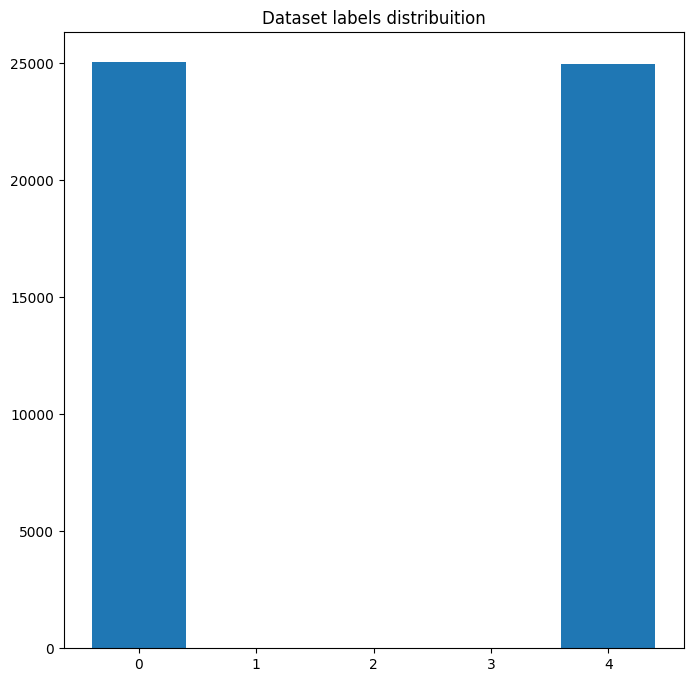

In [287]:
target_cnt = Counter(df.target)

plt.figure(figsize=(8,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [288]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [289]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [290]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 1.84 s
Wall time: 1.9 s


### Split train and test

In [291]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


### Word2Vec 

In [292]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 2.39 s
Wall time: 4.77 s


In [293]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)



2024-03-04 14:18:30,113 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-03-04T14:18:30.113351', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [294]:
w2v_model.build_vocab(documents)

2024-03-04 14:18:30,135 : INFO : collecting all words and their counts
2024-03-04 14:18:30,139 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-04 14:18:30,169 : INFO : PROGRESS: at sentence #10000, processed 72646 words, keeping 14102 word types
2024-03-04 14:18:30,200 : INFO : PROGRESS: at sentence #20000, processed 145419 words, keeping 21792 word types
2024-03-04 14:18:30,233 : INFO : PROGRESS: at sentence #30000, processed 217034 words, keeping 27744 word types
2024-03-04 14:18:30,254 : INFO : collected 33075 word types from a corpus of 290047 raw words and 40000 sentences
2024-03-04 14:18:30,262 : INFO : Creating a fresh vocabulary
2024-03-04 14:18:30,274 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 3327 unique words (10.06% of original 33075, drops 29748)', 'datetime': '2024-03-04T14:18:30.274881', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platfo

In [295]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-03-04 14:18:30,398 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 3327 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2024-03-04T14:18:30.398418', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2024-03-04 14:18:30,740 : INFO : EPOCH 0: training on 290047 raw words (213204 effective words) took 0.3s, 715343 effective words/s
2024-03-04 14:18:31,021 : INFO : EPOCH 1: training on 290047 raw words (213102 effective words) took 0.3s, 817436 effective words/s
2024-03-04 14:18:31,332 : INFO : EPOCH 2: training on 290047 raw words (213152 effective words) took 0.3s, 759938 effective words/s
2024-03-04 14:18:31,645 : INFO : EPOCH 3: training on 290047 raw words (213304 effective words) took 0.2s, 881426 effective words/s
2024-03-04 14:18:31,999 : INFO : EPOCH 4: training on

CPU times: total: 48.3 s
Wall time: 9.83 s


(6821604, 9281504)

In [296]:
from gensim.models import FastText


fasttext_model = FastText(vector_size=W2V_SIZE, # Dimensionality of word embeddings
                      window=6,                             # Context window for words during training
                      min_count=3,                          # Minimun threshold of word frequency
                      workers=8,
                      epochs=20)                            # Number of epochs training over corpus
fasttext_model.build_vocab(documents)

2024-03-04 14:18:40,251 : INFO : FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-03-04T14:18:40.251713', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
2024-03-04 14:18:40,652 : INFO : collecting all words and their counts
2024-03-04 14:18:40,652 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-04 14:18:40,666 : INFO : PROGRESS: at sentence #10000, processed 72646 words, keeping 14102 word types
2024-03-04 14:18:40,698 : INFO : PROGRESS: at sentence #20000, processed 145419 words, keeping 21792 word types
2024-03-04 14:18:40,729 : INFO : PROGRESS: at sentence #30000, processed 217034 words, keeping 27744 word types
2024-03-04 14:18:40,754 : INFO : collected 33075 word types from a corpus of 290047 raw words and 40000 sentences
2024-03-04 14:18:40,754 : INFO : Creating a f

In [297]:
%%time
fasttext_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-03-04 14:18:47,514 : INFO : FastText lifecycle event {'msg': 'training model with 8 workers on 8969 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=6 shrink_windows=True', 'datetime': '2024-03-04T14:18:47.514840', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2024-03-04 14:18:48,581 : INFO : EPOCH 0 - PROGRESS: at 65.57% examples, 152848 words/s, in_qsize 11, out_qsize 0
2024-03-04 14:18:48,898 : INFO : EPOCH 0: training on 290047 raw words (242930 effective words) took 1.4s, 179311 effective words/s
2024-03-04 14:18:49,931 : INFO : EPOCH 1 - PROGRESS: at 75.94% examples, 180229 words/s, in_qsize 8, out_qsize 0
2024-03-04 14:18:50,131 : INFO : EPOCH 1: training on 290047 raw words (243106 effective words) took 1.2s, 198603 effective words/s
2024-03-04 14:18:51,188 : INFO : EPOCH 2 - PROGRESS: at 79.47% examples, 189464 words/s, i

CPU times: total: 4min 26s
Wall time: 41.3 s


(7779385, 9281504)

### Tokenize Text

In [298]:
# %%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 33076
CPU times: total: 688 ms
Wall time: 690 ms


In [299]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Label Encoder 

In [300]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

[0, 4, 'NEUTRAL']

In [301]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [302]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


### Embedding layer

In [303]:
from keras.layers import Embedding
Embedding_dimensions = 300
def createEmbeddingMatrix(model, modelName):
  embedding_matrix = np.zeros((vocab_size, Embedding_dimensions))
  for word, i in tokenizer.word_index.items():
      if word in model.wv:
        embedding_matrix[i] = model.wv[word]
  print("Embedded matrix shape for ", modelName ,":", embedding_matrix.shape)
  return embedding_matrix

In [304]:
# embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [305]:
embedding_layer_word2vec = Embedding(vocab_size, W2V_SIZE, weights=[createEmbeddingMatrix(w2v_model, "Word2vec")], input_length=SEQUENCE_LENGTH, trainable=False)
embedding_layer_fasttext = Embedding(vocab_size,W2V_SIZE, weights=[createEmbeddingMatrix(fasttext_model, "FastText")], input_length=SEQUENCE_LENGTH, trainable=False)

Embedded matrix shape for  Word2vec : (33076, 300)


Embedded matrix shape for  FastText : (33076, 300)


### Build Model

In [306]:
lstm_w2v = Sequential()
lstm_w2v.add(embedding_layer_word2vec)
lstm_w2v.add(Dropout(0.5))
lstm_w2v.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_w2v.add(Dense(1, activation='sigmoid'))

lstm_w2v.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 300)          9922800   
                                                                 
 dropout_10 (Dropout)        (None, 300, 300)          0         
                                                                 
 lstm_10 (LSTM)              (None, 100)               160400    
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 10083301 (38.46 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 9922800 (37.85 MB)
_________________________________________________________________


### Compile model

In [307]:
lstm_w2v.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [308]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [309]:
%%time
history_lstm_w2v = lstm_w2v.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8


71/71 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.6827 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:34:34,367 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 902s 13s/step - loss: 0.5874 - accuracy: 0.6827 - val_loss: 0.5457 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 2/8
71/71 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7132WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:39:32,830 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 298s 4s/step - loss: 0.5559 - accuracy: 0.7132 - val_loss: 0.5357 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 3/8
71/71 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7186WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:44:31,622 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 299s 4s/step - loss: 0.5425 - accuracy: 0.7186 - val_loss: 0.5292 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 4/8
71/71 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7062WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:49:36,635 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 305s 4s/step - loss: 0.5707 - accuracy: 0.7062 - val_loss: 0.5360 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 5/8
71/71 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.7212WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:54:45,005 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 308s 4s/step - loss: 0.5378 - accuracy: 0.7212 - val_loss: 0.5239 - val_accuracy: 0.7315 - lr: 0.0010
Epoch 6/8
71/71 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7287WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 14:59:56,521 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 312s 4s/step - loss: 0.5283 - accuracy: 0.7287 - val_loss: 0.5222 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 7/8
71/71 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7339 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 15:14:32,072 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 876s 12s/step - loss: 0.5231 - accuracy: 0.7339 - val_loss: 0.5180 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 8/8
71/71 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.7356WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 15:19:31,416 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 299s 4s/step - loss: 0.5189 - accuracy: 0.7356 - val_loss: 0.5175 - val_accuracy: 0.7377 - lr: 0.0010
CPU times: total: 3h 34min 25s
Wall time: 59min 59s


In [310]:
lstm_fast = Sequential()
lstm_fast.add(embedding_layer_fasttext)
lstm_fast.add(Dropout(0.5))
lstm_fast.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_fast.add(Dense(1, activation='sigmoid'))

lstm_fast.summary()

lstm_fast.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


history_lstm_fast = lstm_fast.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 300)          9922800   
                                                                 
 dropout_11 (Dropout)        (None, 300, 300)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               160400    
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 10083301 (38.46 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 9922800 (37.85 MB)
_________________________________________________________________
Epoch 1/8
71/71 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.6824WARNING:tensorflow:Early stopping conditioned o

2024-03-04 15:24:43,430 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 312s 4s/step - loss: 0.5892 - accuracy: 0.6824 - val_loss: 0.5464 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 2/8
71/71 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7141WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 15:29:44,915 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 301s 4s/step - loss: 0.5543 - accuracy: 0.7141 - val_loss: 0.5377 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 3/8
71/71 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7231  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 18:05:38,430 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 9354s 134s/step - loss: 0.5409 - accuracy: 0.7231 - val_loss: 0.5289 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 4/8
71/71 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7300WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 18:16:12,321 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 634s 9s/step - loss: 0.5336 - accuracy: 0.7300 - val_loss: 0.5254 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 5/8
71/71 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7297WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 18:26:36,083 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 624s 9s/step - loss: 0.5288 - accuracy: 0.7297 - val_loss: 0.5219 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 6/8
71/71 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.7364  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 19:38:34,372 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 4318s 62s/step - loss: 0.5213 - accuracy: 0.7364 - val_loss: 0.5211 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 7/8
71/71 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7404WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 19:43:31,274 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 297s 4s/step - loss: 0.5160 - accuracy: 0.7404 - val_loss: 0.5217 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 8/8
71/71 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7434WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2024-03-04 19:48:29,641 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


71/71 [==============================] - 298s 4s/step - loss: 0.5134 - accuracy: 0.7434 - val_loss: 0.5167 - val_accuracy: 0.7390 - lr: 0.0010


## Evaluation of LSTM with Word2Vec

### Evaluate

In [311]:
score = lstm_w2v.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

20/20 [==============================] - 8s 403ms/step - loss: 0.5191 - accuracy: 0.7387

ACCURACY: 0.7386999726295471
LOSS: 0.5191376209259033


In [312]:
y_pred=(lstm_w2v.predict(x_test)>=0.5).astype(int)

313/313 [==============================] - 30s 95ms/step


Roc Curve of LSTM with Word2Vec

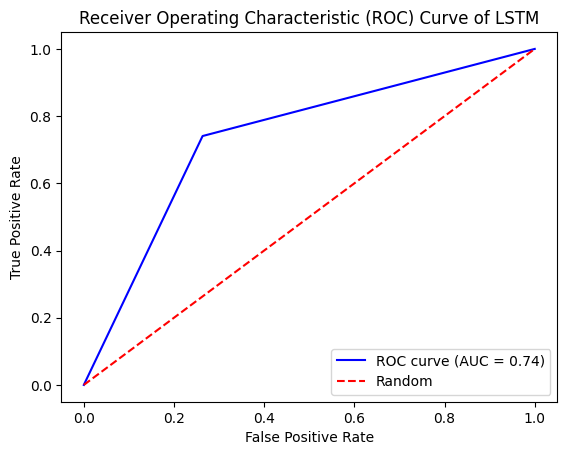

In [313]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics



# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)

# Calculate the AUC (Area Under the Curve)
auc = metrics.roc_auc_score(y_test,y_pred)

# Create the ROC plot
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of LSTM')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix of LSTM with Word2Vec

In [314]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

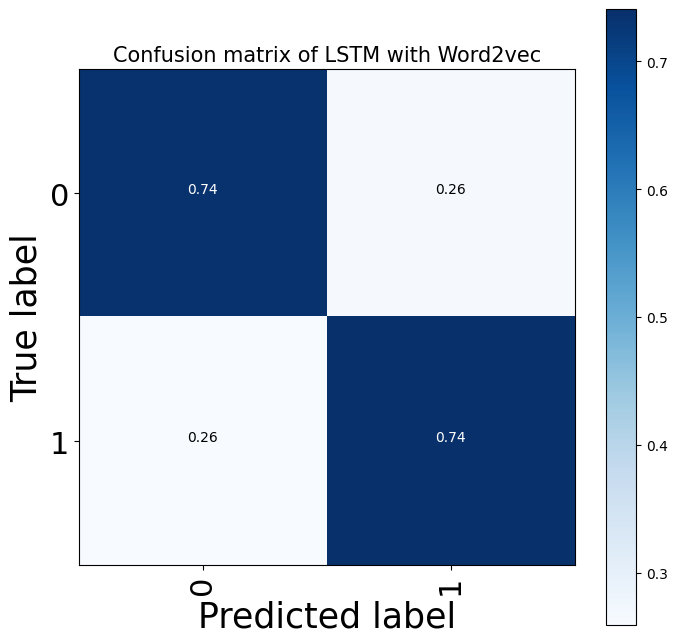

CPU times: total: 156 ms
Wall time: 156 ms


In [315]:
%%time

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix of LSTM with Word2vec")
plt.show()

Classification Report of LSTM with Word2vec

In [316]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4943
           1       0.74      0.74      0.74      5057

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

0.7387


### Lstm With Fast Text

In [317]:
score = lstm_fast.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])
y_pred = (lstm_fast.predict(x_test)>=0.5).astype(int)

20/20 [==============================] - 8s 398ms/step - loss: 0.5231 - accuracy: 0.7401

ACCURACY: 0.7401000261306763
LOSS: 0.5231202840805054
313/313 [==============================] - 30s 95ms/step


Roc Curve of LSTM with Fast Text

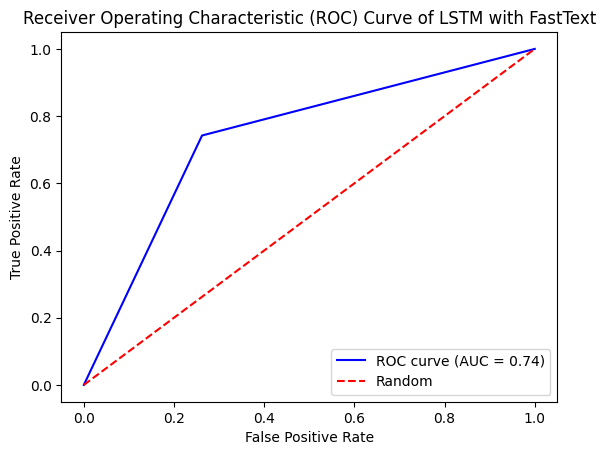

In [318]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics



# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)

# Calculate the AUC (Area Under the Curve)
auc = metrics.roc_auc_score(y_test,y_pred)

# Create the ROC plot
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of LSTM with FastText')
plt.legend(loc='lower right')
plt.show()

ConfusionMatrix of LSTM with FastText

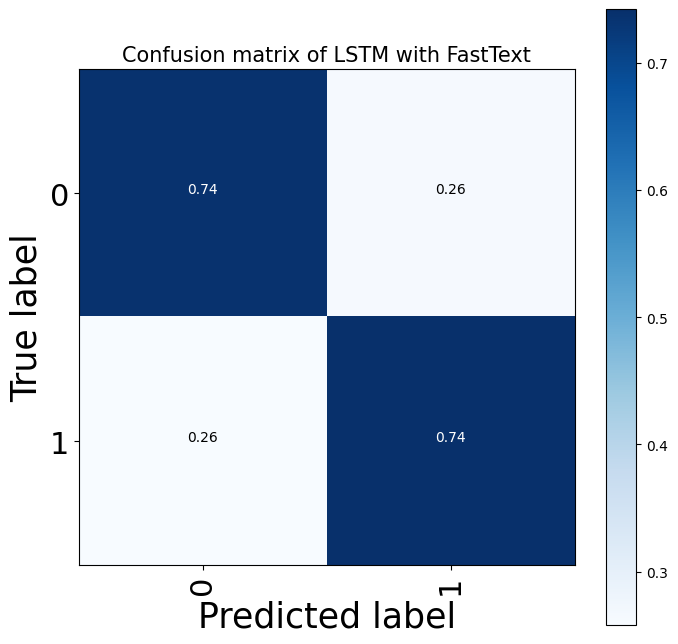

CPU times: total: 266 ms
Wall time: 290 ms


In [319]:
%%time

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix of LSTM with FastText")
plt.show()

Classificatin and Accuracy of LSTN with FastText

In [320]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4943
           1       0.74      0.74      0.74      5057

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

0.7401


## DistilBert

In [1]:

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the fine-tuned model from Hugging Face
model_name = "sohan-ai/sentiment-analysis-model-amazon-reviews"
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(model_name)

# Tokenize input text
text = "Not like the product at all"
inputs = tokenizer(text, return_tensors="pt")

# Make prediction
outputs = model(**inputs)
predicted_label = "positive" if outputs.logits.argmax().item() == 1 else "negative"

print(f"Predicted sentiment: {predicted_label}")


c:\Users\Faizan220985\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted sentiment: negative
